Restarted Python

In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz

import torch
from torch.utils.data import DataLoader

from models.conv1d import StarClassifier2_old
from eval_utils import label_field, stellar_metrics

In [2]:
hdul = fits.open('data/dataset_subset2.fits')
dataset = hdul[1].data
hdul.close()

In [3]:
problem = np.where(np.bitwise_and(dataset.SPEC == 5, dataset.LUM == 5))
dataset = np.delete(dataset, problem)
problem2 = np.where(dataset.TYPED_ID == 'HD 154660')
dataset.ID[problem2] = '154660_1'

label_conv = label_field(dataset, regr=False)

# indices = label_conv.ord_to_idx(label_conv.classes)

In [4]:
all_numpy = dataset.FLUX.newbyteorder().byteswap()
all_torch = torch.tensor(all_numpy).float().cuda()

dataloader = DataLoader(all_torch, batch_size=32)

val_indices = np.load('val_indices_cls.npy')
test_indices = np.load('test_indices_cls.npy')

In [5]:
fs = [128//(2**i) for i in range(1,5)]
fs.insert(0,1)

model_config = {'filter_sizes':fs,
                'output_dim':40,
                'hidden_dim':2048,
                'dropout':0.1}

classifier2 = StarClassifier2_old(**model_config).to('cuda')
classifier2.load_state_dict(torch.load('models/weights/conv1d/cls/best_conv1d_wandb.pth.tar'))
classifier2.eval()

preds = np.empty(0)
logits = np.empty(0)

for batch in dataloader:
    with torch.no_grad():
        class_scores = classifier2(batch).detach().cpu().numpy()
    
        preds = np.append(preds, np.argmax(class_scores, axis=-1))
        logits = np.append(logits, class_scores) 

logits = logits.reshape(-1, 40)

(0.8850602697166786, 0.701926157856893)


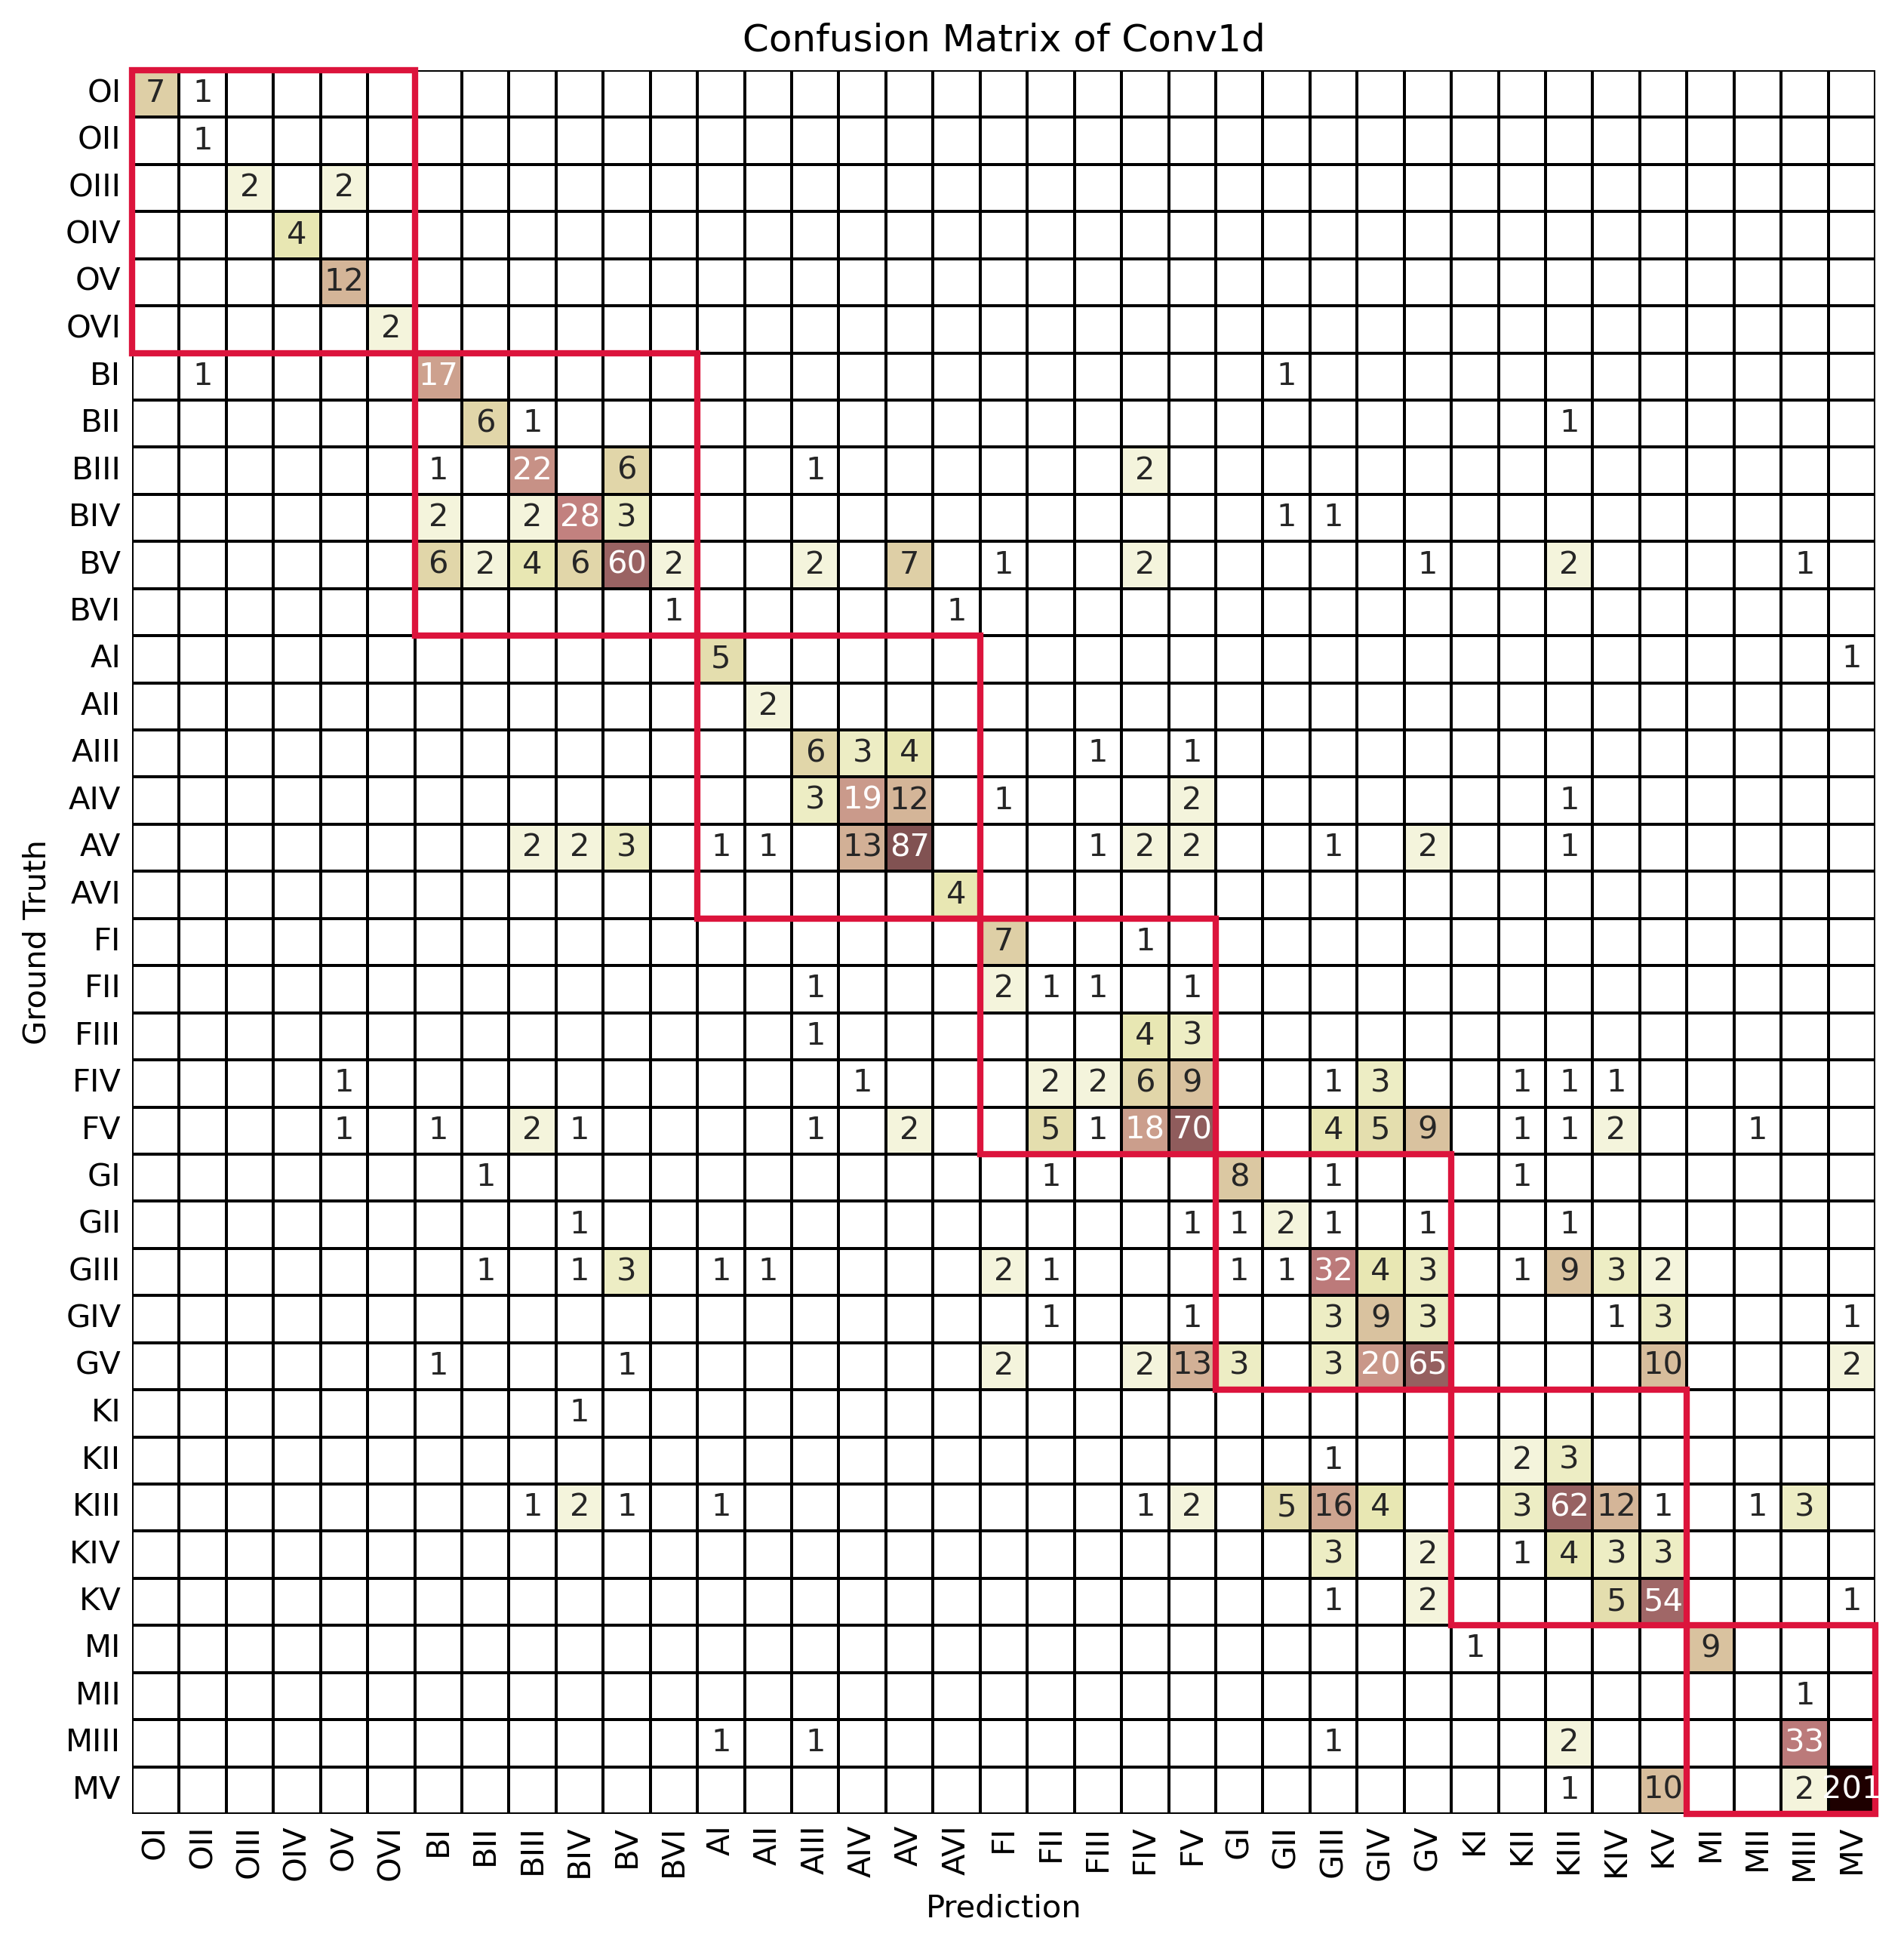

In [8]:
test_preds = label_conv.idx_to_ord(
    preds[test_indices]
)

test_labels = label_conv.classes[test_indices]

test = stellar_metrics(
    label_conv,
    test_preds, 
    test_labels, 
    weighting='quadratic',
    regr=False)

print(test.two_stage_qwk())

test.draw_cm(title='Confusion Matrix of Conv1d', dpi=300)
import matplotlib.pyplot as plt
plt.savefig('conf_conv1d.svg', transparent=True, dpi=300)

In [9]:
pd.DataFrame(test.report()).T

precision    recall  f1-score      support
OI             1.000000  0.875000  0.933333     8.000000
OII            0.333333  1.000000  0.500000     1.000000
OIII           1.000000  0.500000  0.666667     4.000000
OIV            1.000000  1.000000  1.000000     4.000000
OV             0.750000  1.000000  0.857143    12.000000
OVI            1.000000  1.000000  1.000000     2.000000
BI             0.607143  0.894737  0.723404    19.000000
BII            0.600000  0.750000  0.666667     8.000000
BIII           0.647059  0.687500  0.666667    32.000000
BIV            0.666667  0.756757  0.708861    37.000000
BV             0.779221  0.625000  0.693642    96.000000
BVI            0.333333  0.500000  0.400000     2.000000
AI             0.555556  0.833333  0.666667     6.000000
AII            0.500000  1.000000  0.666667     2.000000
AIII           0.375000  0.400000  0.387097    15.000000
AIV            0.527778  0.500000  0.513514    38.000000
AV             0.776786  0.737288  0.756522   118.000000
AVI            0.800000  1.000000  0.888889     4.000000
FI             0.466667  0.875000  0.608696     8.000000
FII            0.090909  0.166667  0.117647     6.000000
FIII           0.000000  0.000000  0.000000     8.000000
FIV            0.157895  0.214286  0.181818    28.000000
FV             0.666667  0.560000  0.608696   125.000000
GI             0.615385  0.666667  0.640000    12.000000
GII            0.200000  0.250000  0.222222     8.000000
GIII           0.463768  0.484848  0.474074    66.000000
GIV            0.200000  0.409091  0.268657    22.000000
GV             0.738636  0.532787  0.619048   122.000000
KI             0.000000  0.000000  0.000000     1.000000
KII            0.200000  0.333333  0.250000     6.000000
KIII           0.696629  0.539130  0.607843   115.000000
KIV            0.111111  0.187500  0.139535    16.000000
KV             0.650602  0.857143  0.739726    63.000000
MI             1.000000  0.900000  0.947368    10.000000
MII            0.000000  0.000000  0.000000     1.000000
MIII           0.825000  0.868421  0.846154    38.000000
MV             0.975728  0.939252  0.957143   214.000000
accuracy       0.664839  0.664839  0.664839     0.664839
macro avg      0.548942  0.617398  0.565523  1277.000000
weighted avg   0.696760  0.664839  0.673496  1277.000000

In [10]:
pd.DataFrame(test.report('temp')).T

precision    recall  f1-score      support
O              0.911765  1.000000  0.953846    31.000000
B              0.871134  0.871134  0.871134   194.000000
A              0.879121  0.874317  0.876712   183.000000
F              0.760000  0.760000  0.760000   175.000000
G              0.715556  0.700000  0.707692   230.000000
K              0.728571  0.761194  0.744526   201.000000
M              0.957198  0.935361  0.946154   263.000000
accuracy       0.824589  0.824589  0.824589     0.824589
macro avg      0.831906  0.843144  0.837152  1277.000000
weighted avg   0.825300  0.824589  0.824796  1277.000000

In [109]:
import df2img
pd.DataFrame(test.report('lum')).T

precision    recall  f1-score      support
I              0.658537  0.843750  0.739726    64.000000
II             0.280000  0.437500  0.341463    32.000000
III            0.753906  0.694245  0.722846   278.000000
IV             0.390625  0.517241  0.445104   145.000000
V              0.895197  0.820000  0.855950   750.000000
VI             0.800000  1.000000  0.888889     8.000000
accuracy       0.750979  0.750979  0.750979     0.750979
macro avg      0.629711  0.718789  0.665663  1277.000000
weighted avg   0.779272  0.750979  0.761812  1277.000000

In [ ]:
test.mae()

0.3140172278778387

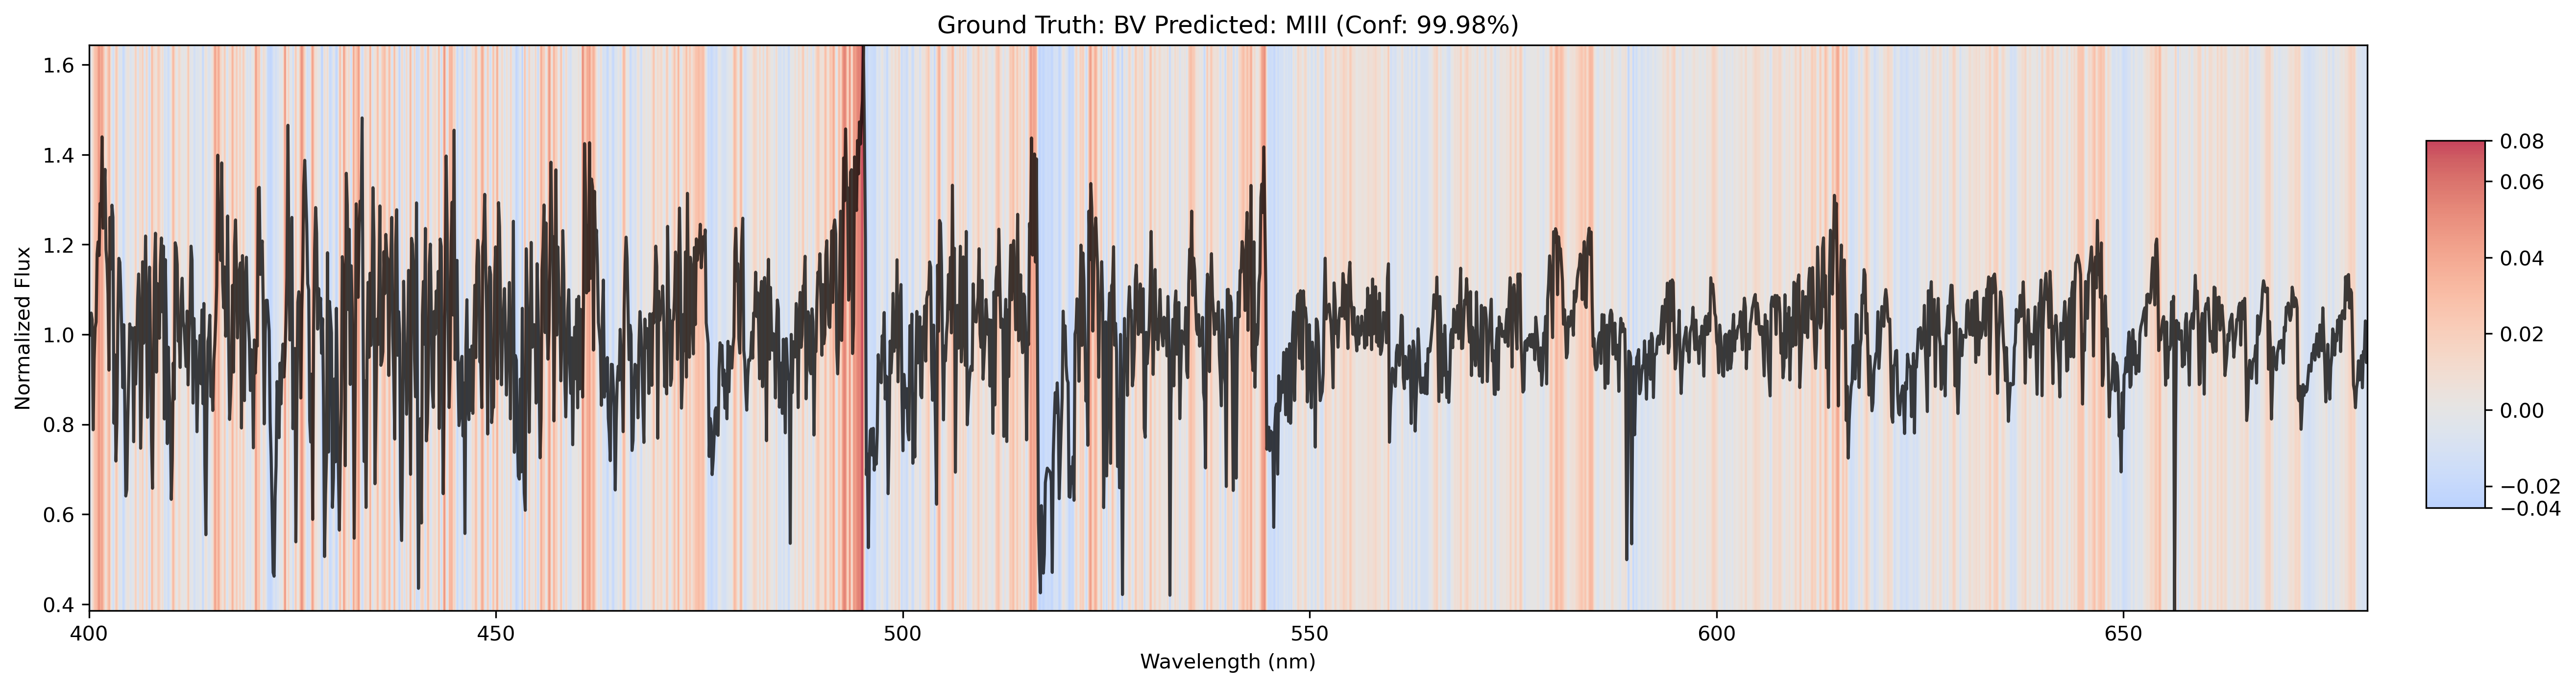

In [26]:
from captum.attr import LayerGradCam, LayerAttribution
import matplotlib.pyplot as plt
from matplotlib import colors

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

def show_attr(label, pred, conv, *args):

    preds_str = label_conv.to_str(preds[test_indices], idx=True)
    ax1 = preds_str == pred
    labs_str = label_conv.to_str(test_labels, idx=False)
    ax2 = labs_str == label

    pred_ix = int(label_conv.__str_degen__(pred, idx=True))

    match conv:
        case 'conv1':
            pass
        case 'conv2':
            layer_gc = LayerGradCam(classifier2, classifier2.convs1[-1])
            layer_gc2 = LayerGradCam(classifier2, classifier2.convs2[-1])
        case 'conv3':
            layer_gc = LayerGradCam(classifier2, classifier2.convs3[-1])

    rows = np.where(ax1 & ax2)[0]

    input_tensor = all_torch[test_indices][rows]
    
    log = logits[test_indices][rows][0]
    conf = softmax(log)

    if len(input_tensor) > 1:
        if len(args) != 0:
            input_tensor = input_tensor[args[0]].unsqueeze(0)
            log = logits[test_indices][rows[args[0]]]
            conf = softmax(log)
            print(f'Showing {args[0]}/{len(rows)}')
        else:
            raise ValueError(f'Please supply an index (Expected 1, got {len(input_tensor)})')



    attr = layer_gc.attribute(input_tensor, pred_ix).detach().cpu()
    attr2 = layer_gc2.attribute(input_tensor, pred_ix).detach().cpu()
    upsampled_attr = LayerAttribution.interpolate(attr, (2305))
    upsampled_attr2 = LayerAttribution.interpolate(attr2, (2305))
    upsampled_attr = upsampled_attr.squeeze(1).numpy()
    upsampled_attr2 = upsampled_attr2.squeeze(1).numpy()
    diff = upsampled_attr - upsampled_attr2

    fig, ax = plt.subplots(dpi=300, figsize=(20,5))
    
    input_arr = input_tensor.squeeze().cpu().numpy()
    iqr = np.diff(np.quantile(input_arr, q=[0.25,0.75]))
    x, y = np.quantile(input_arr, q=[0,1])
    # x /= iqr*4
    # y *= iqr*4

    wave_grid = np.linspace(400,680,2305)
    
    a, b = np.min(diff[0]), np.max(diff[0])
    
    # divnorm=colors.TwoSlopeNorm(vmin=a, vcenter=0, vmax=b)
    divnorm = MidpointNormalize(vmin=a, vmax=b, midpoint=0)
    
    plt.title(f'Ground Truth: {label} Predicted: {pred} (Conf: {conf[pred_ix]:.2%})')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Normalized Flux')
    ax.plot(wave_grid, input_arr, c='k', alpha=0.75)
    im = ax.imshow(diff, zorder=0, extent=(400,680,x,y), aspect='auto',
        cmap='coolwarm', norm=divnorm, alpha=0.75)
    cax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
    fig.colorbar(im, cax=cax, orientation='vertical');

show_attr('BV','MIII','conv2')

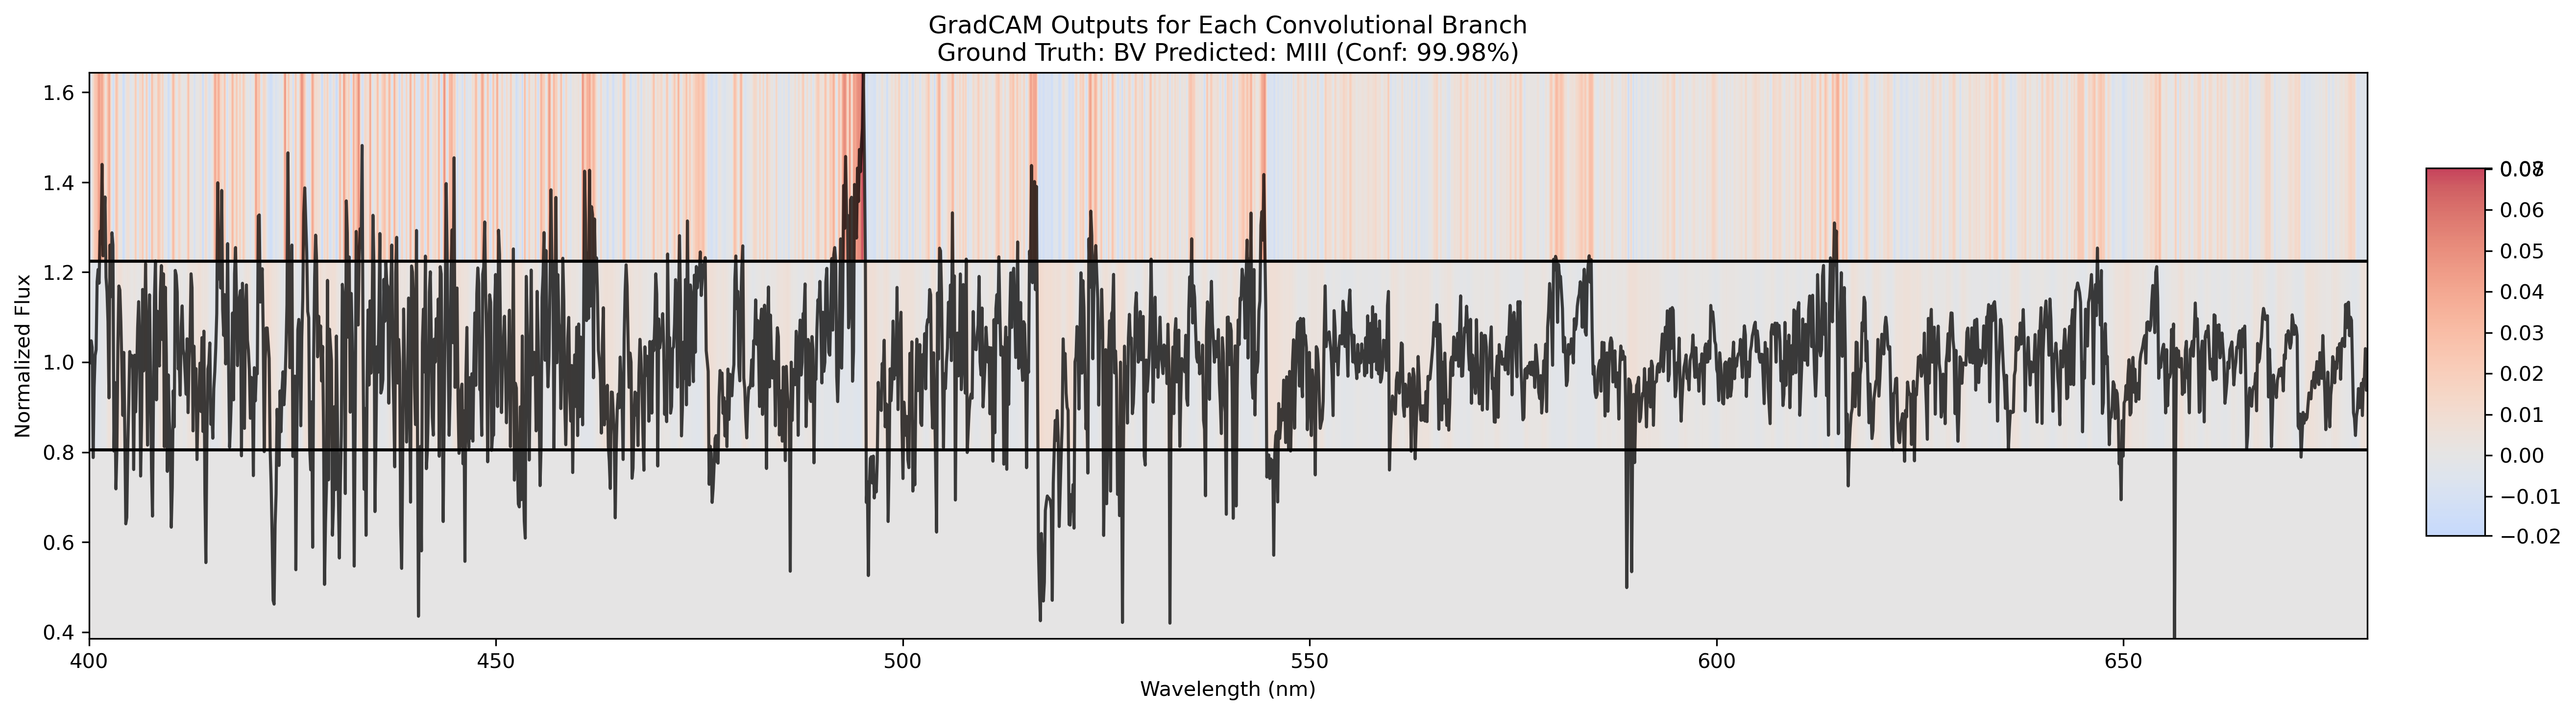

In [111]:
from captum.attr import LayerGradCam, LayerAttribution
import matplotlib.pyplot as plt
from matplotlib import colors

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

def show_attr(label, pred, *args):

    preds_str = label_conv.to_str(preds[test_indices], idx=True)
    ax1 = preds_str == pred
    labs_str = label_conv.to_str(test_labels, idx=False)
    ax2 = labs_str == label

    pred_ix = int(label_conv.__str_degen__(pred, idx=True))

    layer_gc1 = LayerGradCam(classifier2, classifier2.convs1[-1])
    layer_gc2 = LayerGradCam(classifier2, classifier2.convs2[-1])
    layer_gc3 = LayerGradCam(classifier2, classifier2.convs3[-1])

    rows = np.where(ax1 & ax2)[0]

    input_tensor = all_torch[test_indices][rows]
    
    log = logits[test_indices][rows][0]
    conf = softmax(log)

    if len(input_tensor) > 1:
        if len(args) != 0:
            input_tensor = input_tensor[args[0]].unsqueeze(0)
            log = logits[test_indices][rows[args[0]]]
            conf = softmax(log)
            print(f'Showing {args[0]}/{len(rows)}')
        else:
            raise ValueError(f'Please supply an index (Expected 1, got {len(input_tensor)})')


    attr1 = layer_gc1.attribute(input_tensor, pred_ix).detach().cpu()
    attr2 = layer_gc2.attribute(input_tensor, pred_ix).detach().cpu()
    attr3 = layer_gc3.attribute(input_tensor, pred_ix).detach().cpu()
    upsampled_attr1 = LayerAttribution.interpolate(attr1, (2305)).squeeze(1).numpy()
    upsampled_attr2 = LayerAttribution.interpolate(attr2, (2305)).squeeze(1).numpy()
    upsampled_attr3 = LayerAttribution.interpolate(attr3, (2305)).squeeze(1).numpy()

    attrs = np.vstack([
        np.tile(upsampled_attr1, (100,1)), 
        np.tile(upsampled_attr2, (100,1)), 
        np.tile(upsampled_attr3, (100,1))])

    fig, ax = plt.subplots(dpi=300, figsize=(20,5))
    
    input_arr = input_tensor.squeeze().cpu().numpy()
    # iqr = np.diff(np.quantile(input_arr, q=[0.25,0.75]))
    x, y = np.quantile(input_arr, q=[0,1])
    x1, x2 = y-(y-x)/3, (y-x)/3+x
    x3 = (y-x)/2+x
    x4, x5 = x1-x3+x1, x3-x2+x3

    wave_grid = np.linspace(400,680,2305)
    
    a, b = np.min(attrs), np.max(attrs)
    
    # divnorm=colors.TwoSlopeNorm(vmin=a, vcenter=0, vmax=b)
    divnorm = MidpointNormalize(vmin=a, vmax=b, midpoint=0)

    plt.title(f'GradCAM Outputs for Each Convolutional Branch\nGround Truth: {label} Predicted: {pred} (Conf: {conf[pred_ix]:.2%})')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Normalized Flux')
    plt.hlines([x1, x2], xmin=400, xmax=680, colors=['k'])
    ax.plot(wave_grid, input_arr, c='k', alpha=0.75)
    im = ax.imshow(attrs, zorder=0, extent=(400,680,x,y), aspect='auto',
        cmap='coolwarm', norm=divnorm, alpha=0.75)
    cax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
    fig.colorbar(im, cax=cax, orientation='vertical');

show_attr('BV','MIII')
plt.savefig('cam1.svg', dpi=300, transparent=True)

Showing 15/60


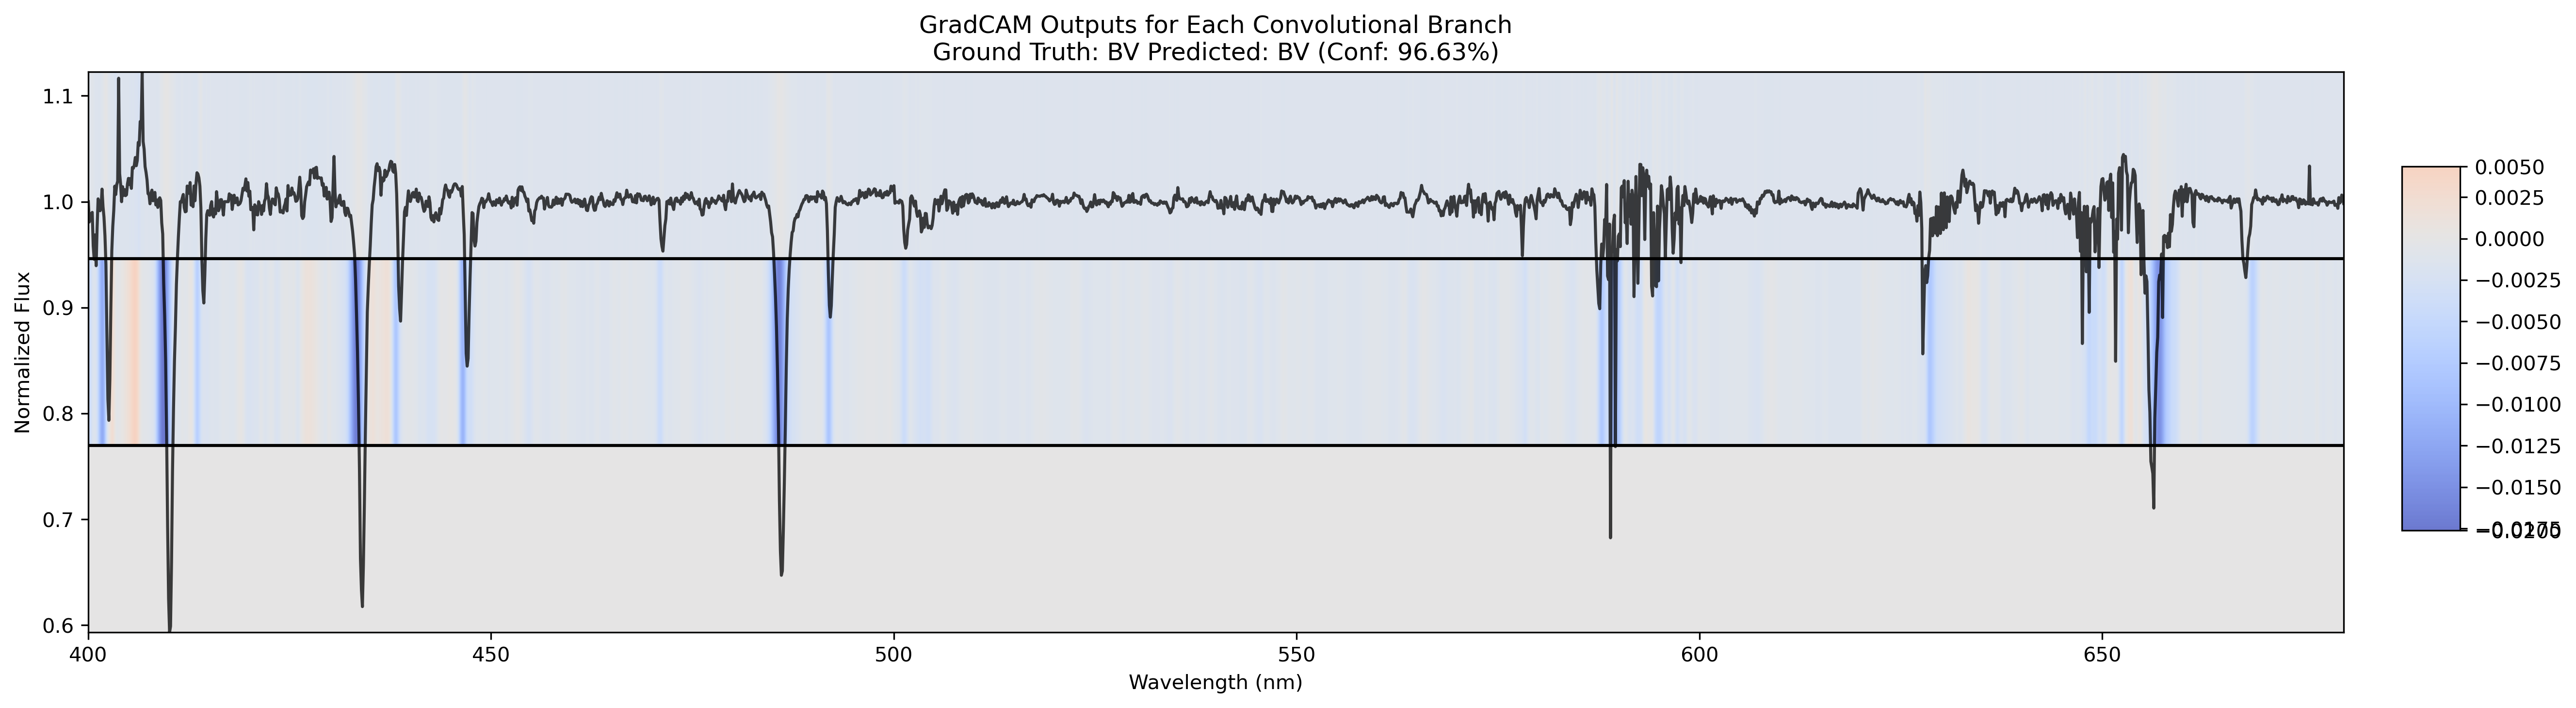

In [112]:
show_attr('BV','BV',15)
plt.savefig('cam2.svg', dpi=300, transparent=True)

Showing 0/2


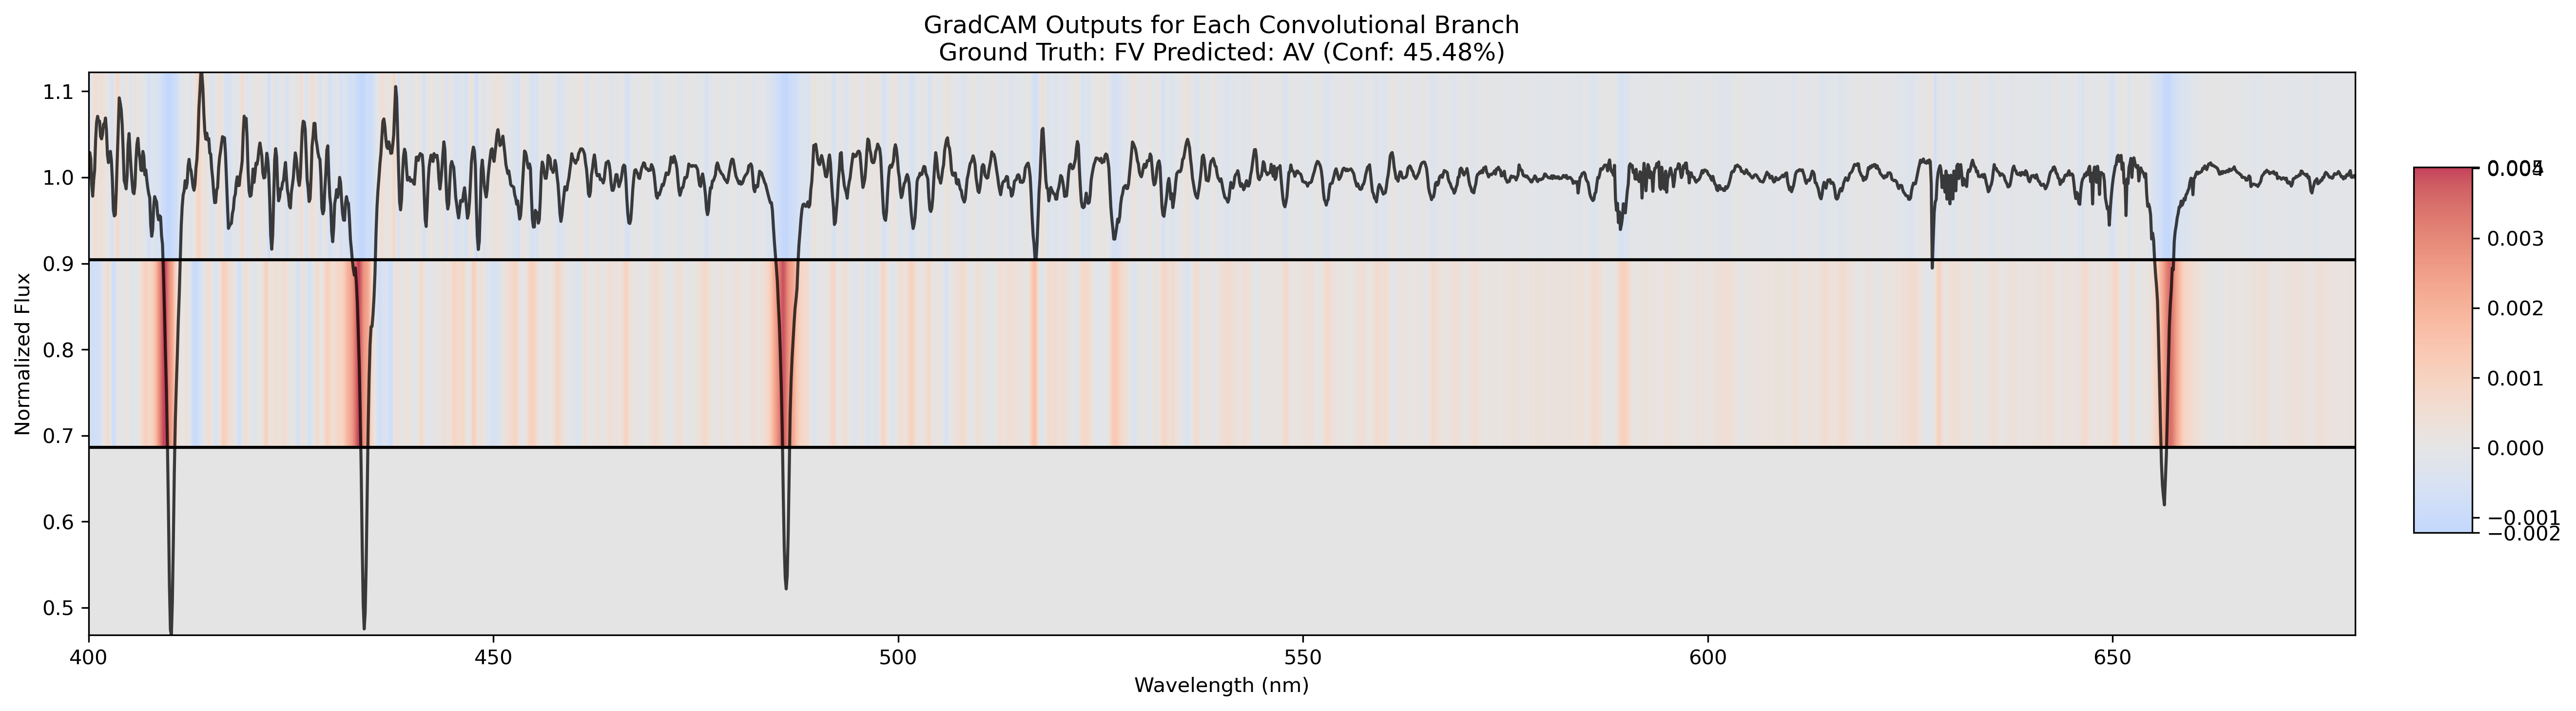

In [79]:
show_attr('FV','AV',0)

Showing 14/70


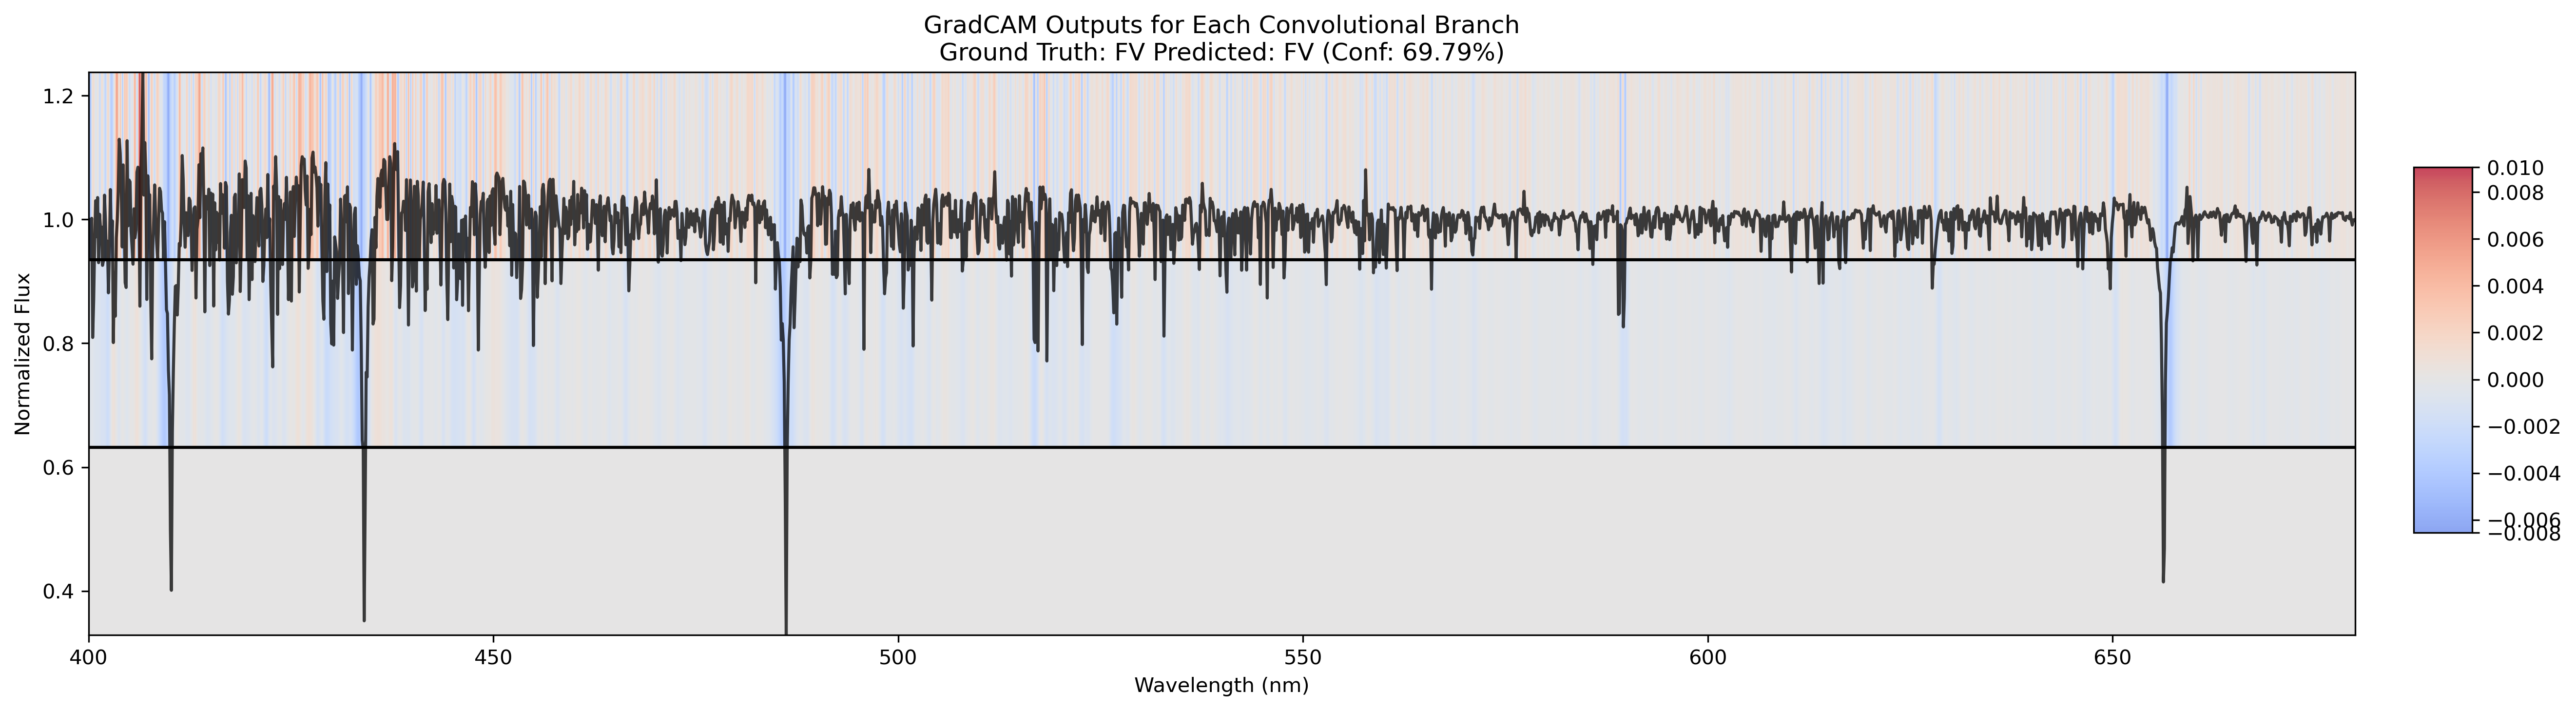

In [96]:
show_attr('FV','FV',14)

Showing 20/87


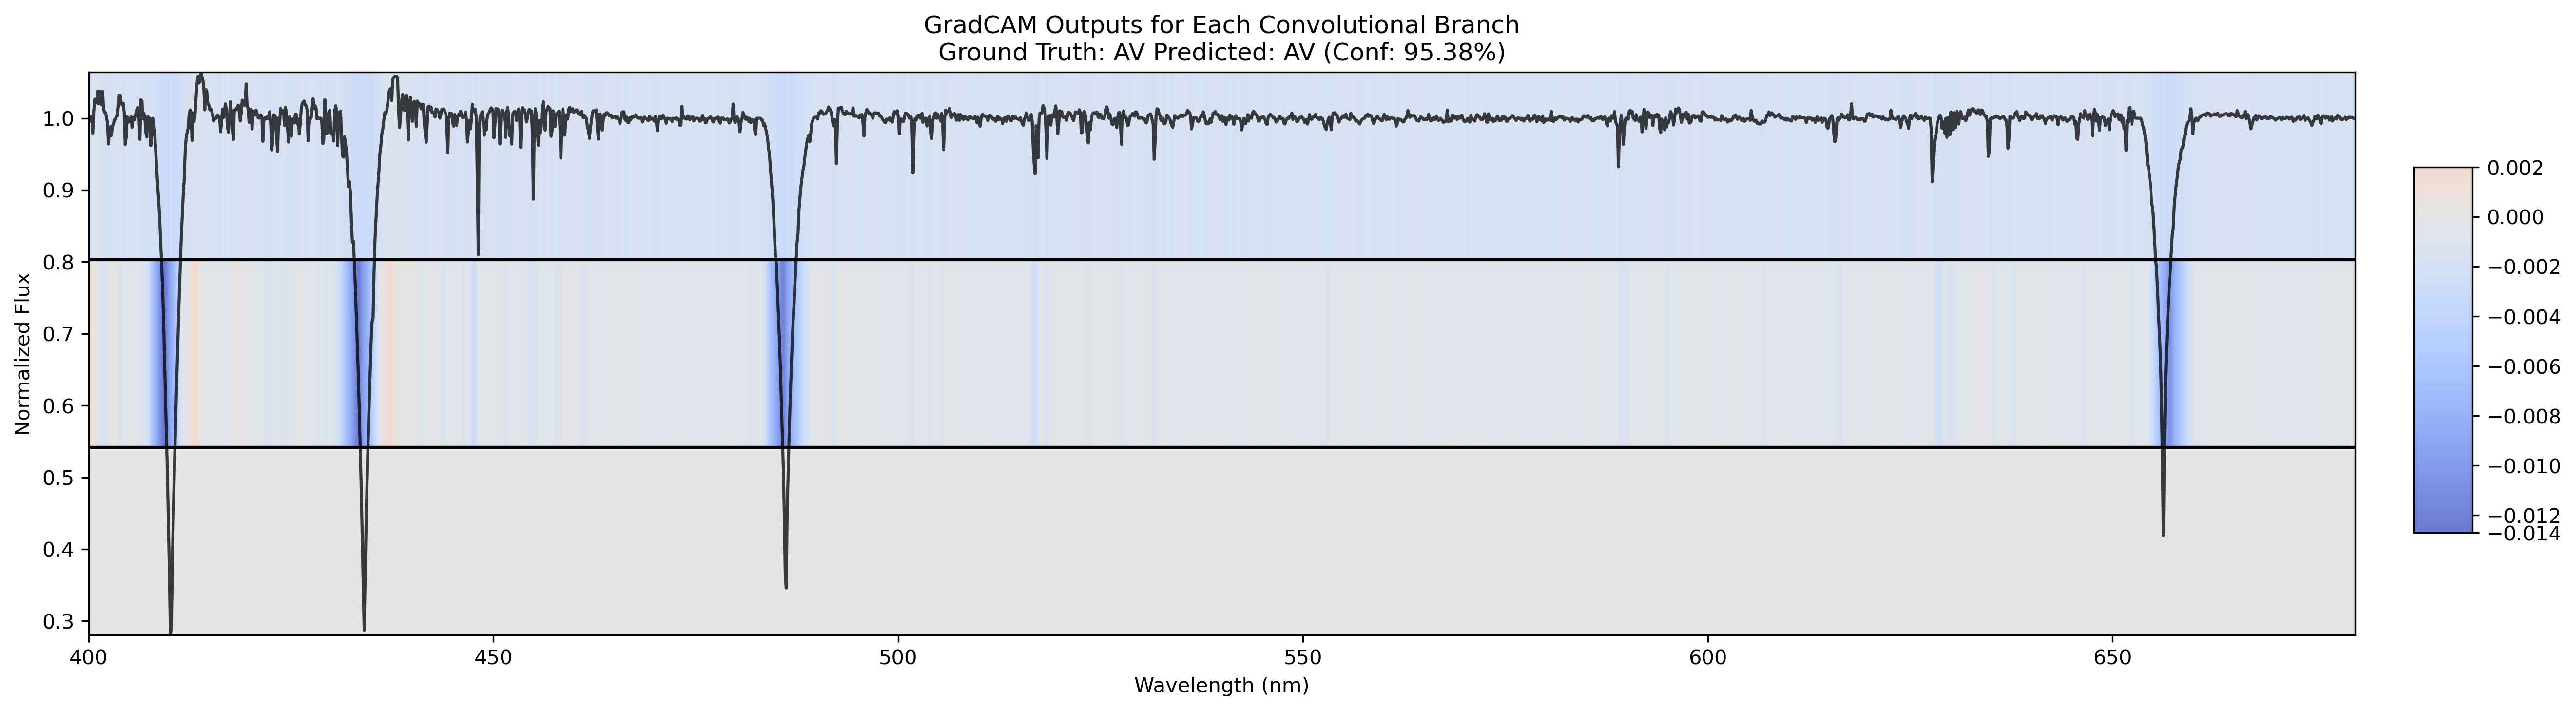

In [84]:
show_attr('AV','AV',20)

Showing 0/5


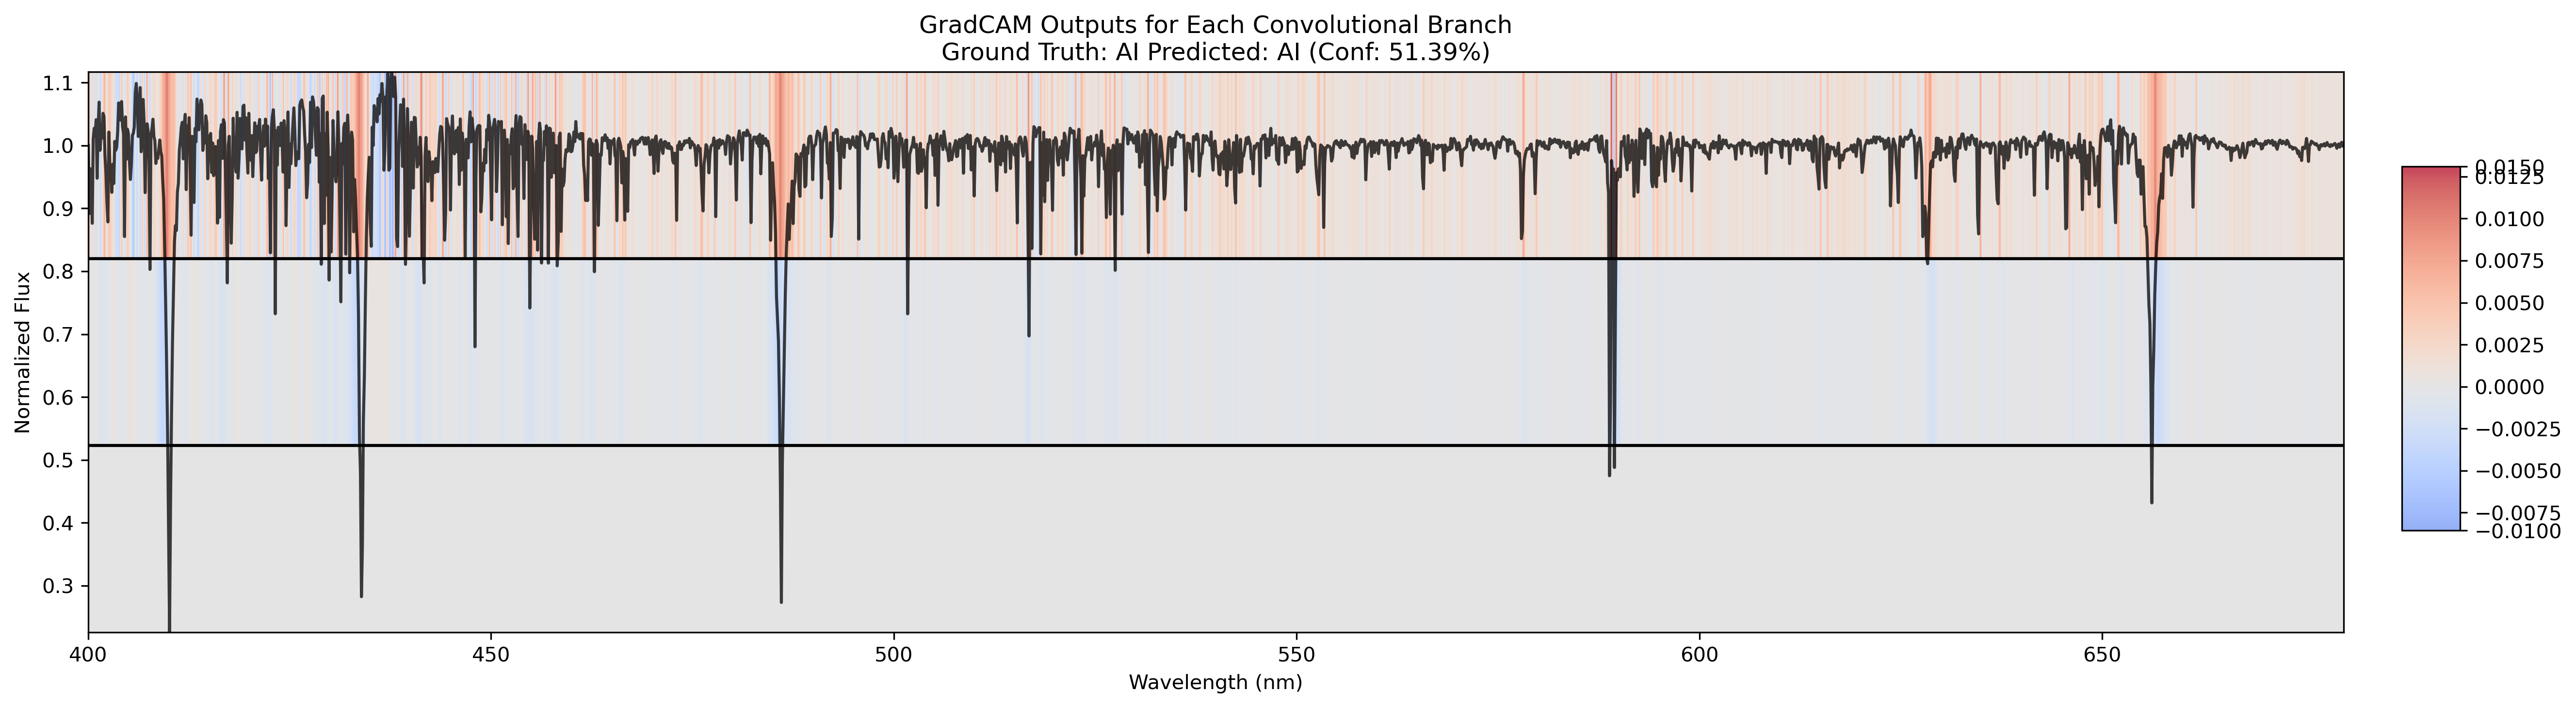

In [88]:
show_attr('AI','AI', 0)

Showing 0/70


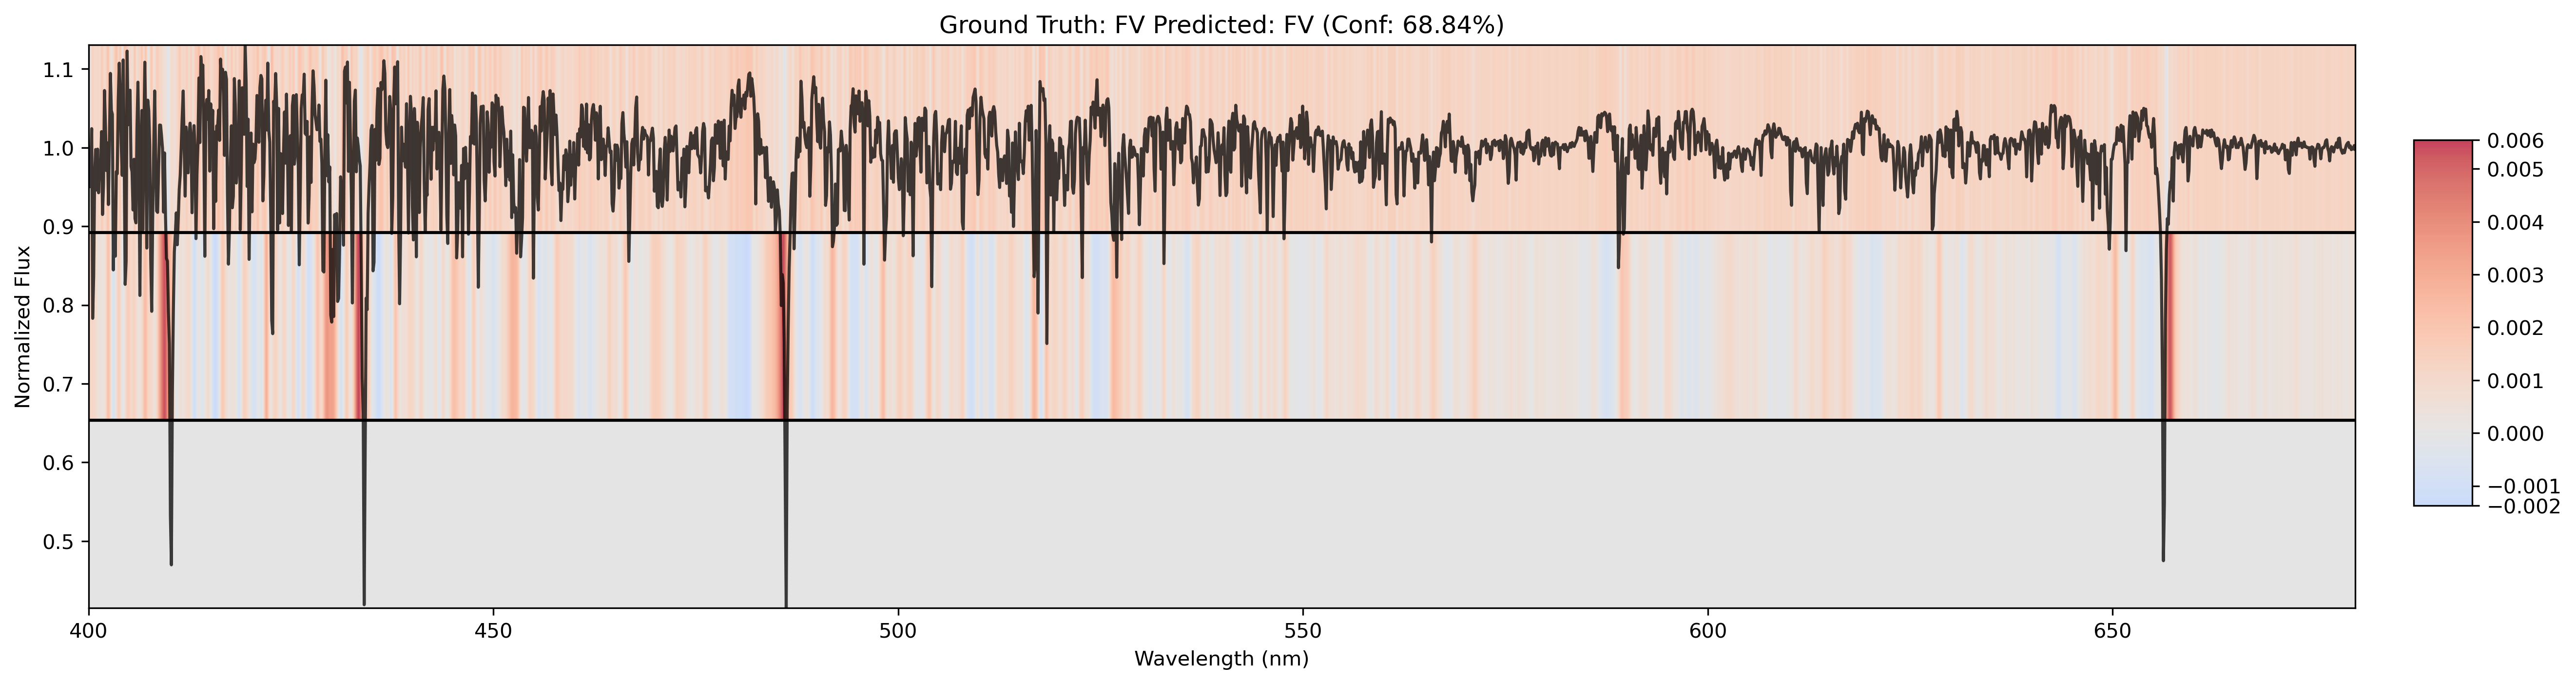

In [71]:
show_attr('FV','FV', 0)

Showing 1/65


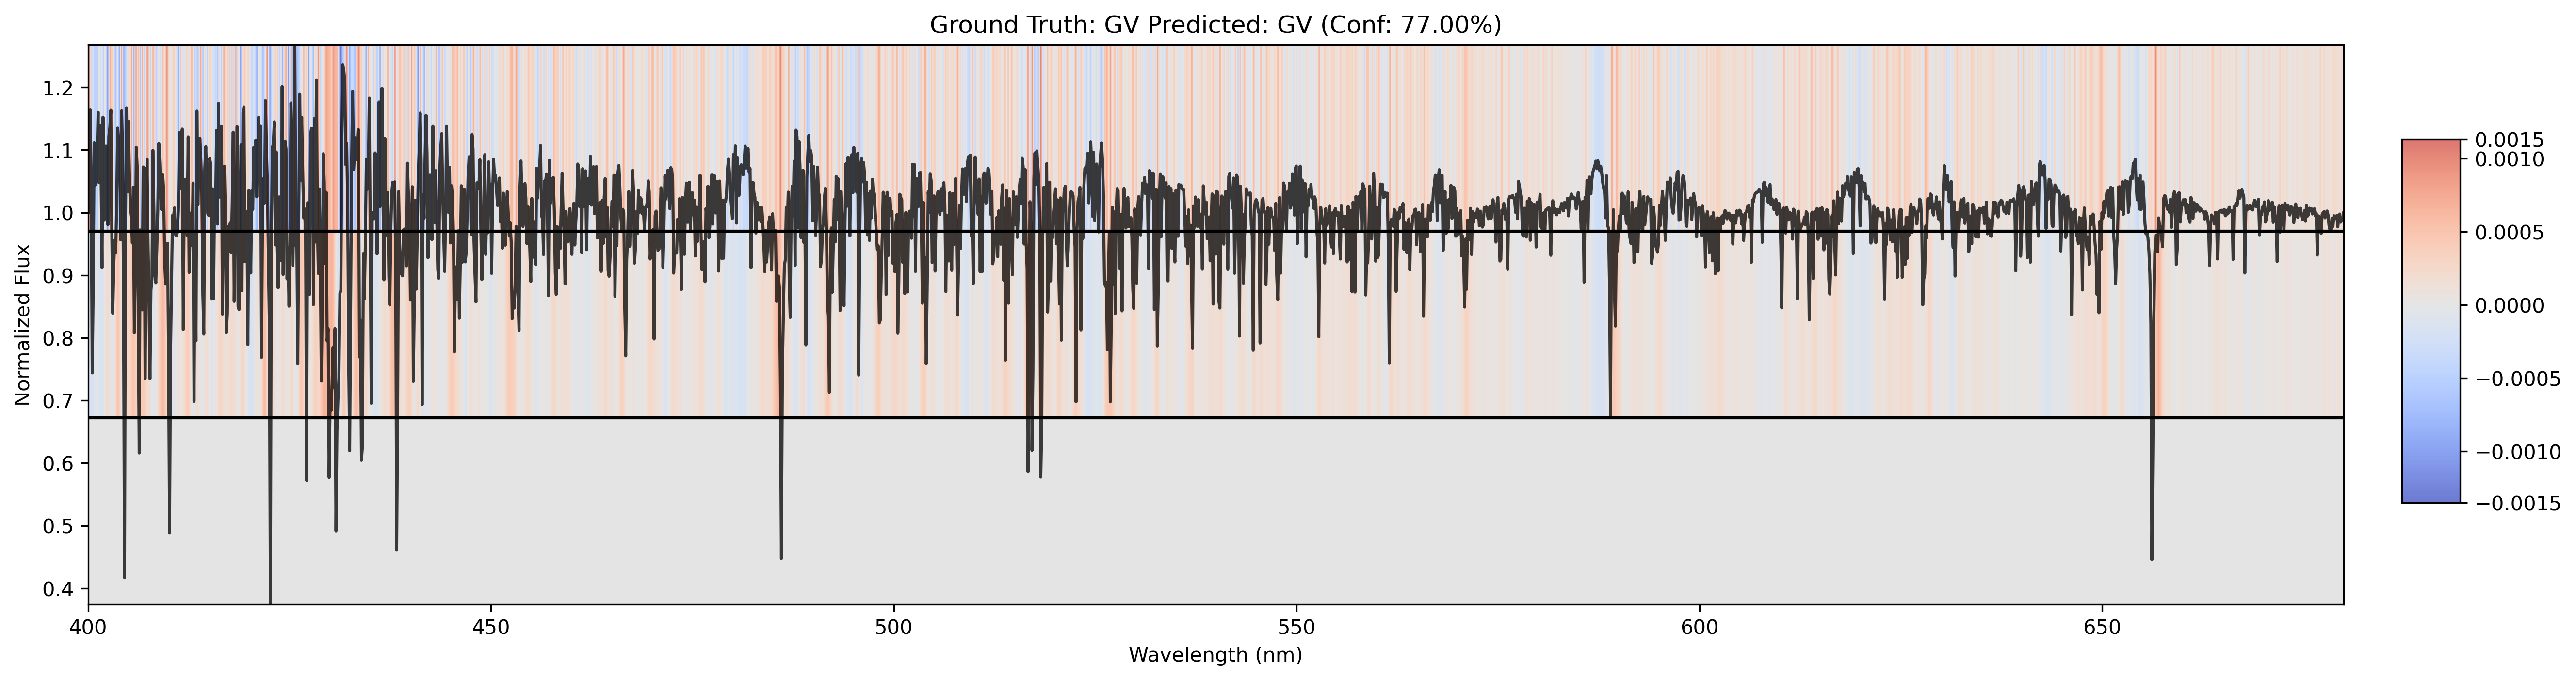

In [74]:
show_attr('GV','GV', 1)

In [ ]:
np.unique(dataset.SPEC,return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.], dtype='>f4'),
 array([ 199, 1482, 1056, 1023, 1504, 1402, 1848]))

<ipython-input-29-2d5358bf8ad9>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('nipy_spectral_r')
<ipython-input-29-2d5358bf8ad9>:14: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=main, y=counts, hue=tex, palette=palet, legend=True)


Text(0.5, 1.0, 'Distribution of main spectral types')

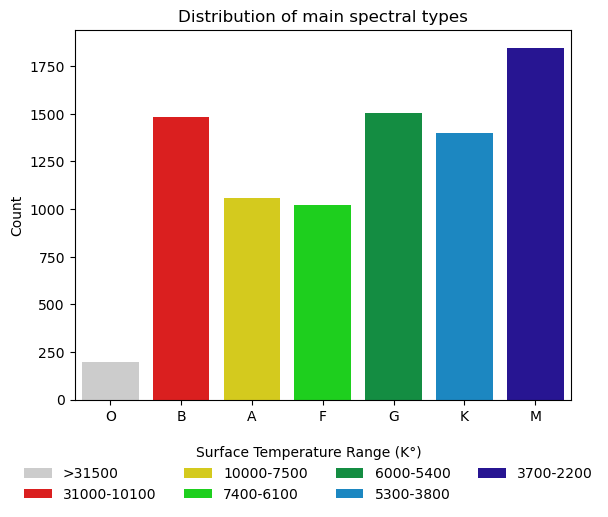

In [ ]:
import seaborn as sns
import matplotlib

main = list('OBAFGKM')
cmap = matplotlib.cm.get_cmap('nipy_spectral_r')
palet = cmap(np.arange(0,1,1/7))

tex = ['>31500', '31000-10100', '10000-7500',
        '7400-6100', '6000-5400', '5300-3800', '3700-2200']

counts = np.unique(dataset.SPEC,return_counts=True)[-1]

sns.barplot(x=main, y=counts, hue=tex, palette=palet, legend=True)
# for i in range(7):
plt.legend(loc='center right', ncols=4, frameon=False, fancybox=True,
                title='Surface Temperature Range (K°)', bbox_to_anchor=(1.07, -0.2))
plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of main spectral types')
# plt.savefig('dist_test.svg',transparent=True, dpi=300)

In [ ]:
hdul = fits.open('data/dataset.fits')
dataset_big = hdul[1].data
hdul.close()

In [ ]:
dataset_big.DATASET

chararray(['CFLIB', 'CFLIB', 'CFLIB', ..., 'SOPHIE', 'SOPHIE', 'SOPHIE'],
          dtype='<U6')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

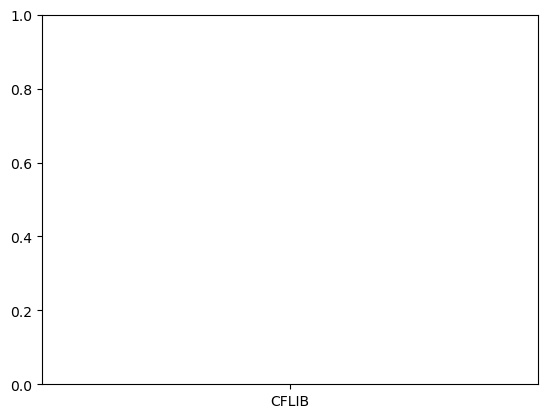

In [ ]:
stuff = np.unique(dataset_big.DATASET,return_counts=True)

sns.barplot(x=stuff[0], y=stuff[1], fill=stuff[0], legend=True)
# for i in range(7):
plt.legend(loc='center right', frameon=False, fancybox=True,
            bbox_to_anchor=(1.07, -0.2))
plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of series')

In [ ]:
stuff[0]

chararray(['CFLIB', 'ELODIE', 'SDSS', 'SOPHIE'], dtype='<U6')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Distribution of series')

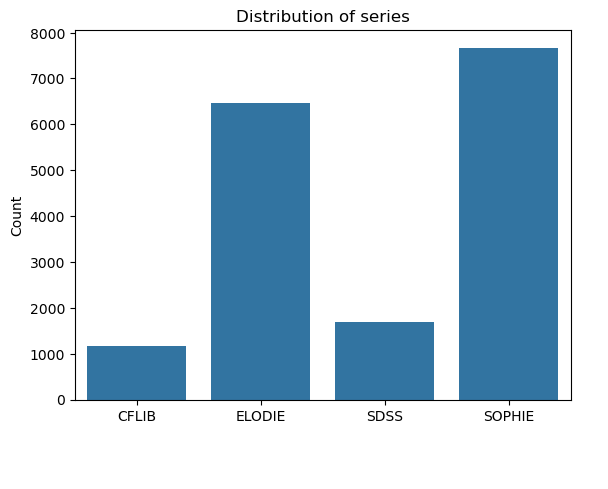

In [ ]:
stuff = np.unique(dataset_big.DATASET,return_counts=True)

sns.barplot(x=stuff[0], y=stuff[1], legend=True)
# for i in range(7):
plt.legend(loc='center right', frameon=False, fancybox=True,
            bbox_to_anchor=(1.07, -0.2))
plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of series')

In [ ]:
stuff = pd.Series(dataset_big.DATASET).value_counts()

stuff = stuff.loc[['SDSS', 'CFLIB', 'ELODIE', 'SOPHIE']]

sns.barplot(x=stuff[0], y=stuff[1], legend=True)

plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of series')

<ipython-input-37-0f8ac3f810ce>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sns.barplot(x=stuff[0], y=stuff[1], legend=True)


ValueError: If using all scalar values, you must pass an index

Text(0.5, 1.0, 'Distribution of series')

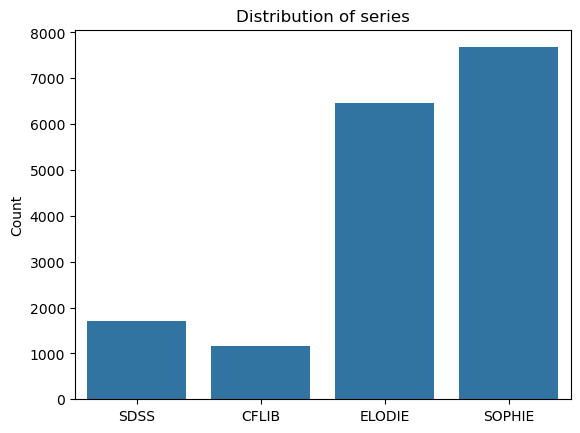

In [ ]:
stuff = pd.Series(dataset_big.DATASET).value_counts()

stuff = stuff.loc[['SDSS', 'CFLIB', 'ELODIE', 'SOPHIE']]

sns.barplot(x=stuff.index, y=stuff.values, legend=True)

plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of series')

In [ ]:
stuff = pd.Series(dataset_big.DATASET).value_counts()
stuff
# 
# stuff = stuff.loc[['SDSS', 'CFLIB', 'ELODIE', 'SOPHIE']]
# 
# sns.barplot(x=stuff.index, y=stuff.values, legend=True)
# 
# plt.xlabel('')
# plt.ylabel('Count')
# plt.title('Distribution of series')

SOPHIE    7675
ELODIE    6455
SDSS      1699
CFLIB     1158
Name: count, dtype: int64

In [ ]:
dataset

FITS_rec([([1.        , 0.94395136, 1.06315649, ..., 1.00085664, 1.00042823, 1.        ], 'G_11-45', 'HD 106116', 'LHS  2524|** LPM  416A|BD-02  3481|CCDM J12125-0305A|Ci 20  688|GC 16674|GCRV  7312|GEN# +1.00106116|G  11-45|G  13-19|GJ 9396|GJ 458.1|HD 106116|HIC  59532|HIP 59532|IDS 12074-0232 A|LFT  883|LPM 416|LTT  4573|2MASS J12122888-0305045|NLTT 29957|PLX 2812|PLX 2812.00|PM 12099-0249|PPM 195261|SAO 138647|SKY# 22903|SPOCS  522|TIC 56812239|TYC 4943-422-1|UBV   10967|UBV M  17884|uvby98 100106116|WDS J12125-0305A|WEB 10584|WISEA J121228.42-030459.6|YZC 17  4527|YZ  92  4527|Gaia DR3 3598278250031419008|Gaia DR1 3598278245734852224|Gaia DR2 3598278250031419008', 'G5V', 'C', '', 'PM*|NIR|MIR|**|*|*', 4., 5., 4.,        nan),
          ([1.        , 0.94743276, 1.0484855 , ..., 1.        , 1.        , 1.        ], 'G_12-24', 'HD 106210', 'LHS  2526|AG+11 1397|ASCC  953524|BD+11  2439|Ci 20  690|Ci 18 1524|GC 16688|GCRV  7316|GEN# +1.00106210|G  12-24|G  57-41|HD 106210|HIC  59589|

In [ ]:
classifier2

StarClassifier2_old(
  (convs1): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (2): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
    (3): Conv1d(16, 8, kernel_size=(3,), stride=(1,))
  )
  (convs2): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,))
    (1): Conv1d(64, 32, kernel_size=(5,), stride=(1,))
    (2): Conv1d(32, 16, kernel_size=(5,), stride=(1,))
    (3): Conv1d(16, 8, kernel_size=(5,), stride=(1,))
  )
  (convs3): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,))
    (1): Conv1d(64, 32, kernel_size=(7,), stride=(1,))
    (2): Conv1d(32, 16, kernel_size=(7,), stride=(1,))
    (3): Conv1d(16, 8, kernel_size=(7,), stride=(1,))
  )
  (linear1): Linear(in_features=6867, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=40, bias=True)
  (drop): Dropout(p=0.1, inplace=False)

In [ ]:
[512/(2**i) for i in range(1,6)]

[256.0, 128.0, 64.0, 32.0, 16.0]